In [ ]:
import string
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.utils import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/  /mydrive

Mounted at /content/gdrive


In [ ]:
def read_file(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [ ]:
data = read_file('/content/gdrive/MyDrive/parser.txt')
data = data.split('\n')

data[:10]

['a01-000u-00-00 ok 154 408 768 27 51 AT A',
 'a01-000u-00-01 ok 154 507 766 213 48 NN MOVE',
 'a01-000u-00-02 ok 154 796 764 70 50 TO to',
 'a01-000u-00-03 ok 154 919 757 166 78 VB stop',
 'a01-000u-00-04 ok 154 1185 754 126 61 NPT Mr.',
 'a01-000u-00-05 ok 154 1438 746 382 73 NP Gaitskell',
 'a01-000u-00-06 ok 154 1896 757 173 72 IN from',
 'a01-000u-01-00 ok 156 395 932 441 100 VBG nominating',
 'a01-000u-01-01 ok 156 901 958 147 79 DTI any',
 'a01-000u-01-02 ok 156 1112 958 208 42 AP more']

In [ ]:
!unzip -q /content/gdrive/MyDrive/words.zip -x "__MACOSX/*"

In [ ]:
import os

extracted_dir = '/content/words'
os.chdir(extracted_dir)


In [ ]:
contents = os.listdir()
print(contents)


['h05', 'p06', 'f01', 'd03', 'c03', 'a03', 'd07', 'h04', 'm04', 'g05', 'c06', 'h01', 'm06', 'd06', 'r02', 'c04', 'd01', 'f07', '.DS_Store', 'm03', 'b05', 'l01', 'r03', 'b06', 'h02', 'a01', 'h07', 'd05', 'n02', 'g02', 'n06', 'r06', 'j07', 'l07', 'p01', 'p03', 'f04', 'p02', 'e07', 'k04', 'd04', 'e06', 'l03', 'g03', 'g07', 'b04', 'h06', 'k01', 'g04', 'm01', 'f03', 'j04', 'e01', 'n03', 'b01', 'a04', 'n04', 'a05', 'k03', 'e02', 'a06', 'a02', 'j01', 'm02', 'l04', 'k02', 'f02', 'c01', 'c02', 'e04', 'j06', 'g06', 'n01', 'b02', 'k07', 'g01', 'b03']


In [ ]:
words_txt_path = os.path.join(extracted_dir, '/content/gdrive/MyDrive/parser.txt')  # Path to words.txt
image_filenames = []

with open(words_txt_path, 'r') as words_txt:
    for line in words_txt:
        image_filename = line.split()[0]
        image_filenames.append(image_filename)

print(image_filenames)

['a01-000u-00-00', 'a01-000u-00-01', 'a01-000u-00-02', 'a01-000u-00-03', 'a01-000u-00-04', 'a01-000u-00-05', 'a01-000u-00-06', 'a01-000u-01-00', 'a01-000u-01-01', 'a01-000u-01-02', 'a01-000u-01-03', 'a01-000u-01-04', 'a01-000u-01-05', 'a01-000u-02-00', 'a01-000u-02-01', 'a01-000u-02-02', 'a01-000u-02-03', 'a01-000u-02-04', 'a01-000u-02-05', 'a01-000u-02-06', 'a01-000u-02-07', 'a01-000u-02-08', 'a01-000u-03-00', 'a01-000u-03-01', 'a01-000u-03-02', 'a01-000u-03-03', 'a01-000u-03-04', 'a01-000u-03-05', 'a01-000u-03-06', 'a01-000u-04-00', 'a01-000u-04-01', 'a01-000u-04-02', 'a01-000u-04-03', 'a01-000u-04-04', 'a01-000u-04-05', 'a01-000u-04-06', 'a01-000u-05-00', 'a01-000u-05-01', 'a01-000u-05-02', 'a01-000u-05-03', 'a01-000u-05-04', 'a01-000u-05-05', 'a01-000u-05-06', 'a01-000u-05-07', 'a01-000u-05-08', 'a01-000u-06-00', 'a01-000u-06-01', 'a01-000u-06-02', 'a01-000u-06-03', 'a01-000u-06-04', 'a01-000u-06-05', 'a01-000u-06-06', 'a01-000x-00-00', 'a01-000x-00-01', 'a01-000x-00-02', 'a01-000x

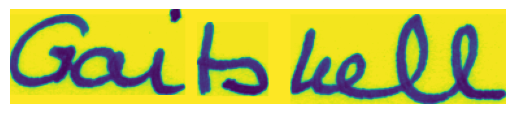

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_filename = '/content/words/a01/a01-000u/a01-000u-00-05.png'
image_path = os.path.join(extracted_dir, 'a01', image_filename)


image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
characters = string.ascii_letters + string.digits + string.punctuation
def encoder(txt):
    output = []
    for index, character in enumerate(txt):
        output.append(characters.index(character))
    return output
print(characters,len(characters))

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 94


In [ ]:
def transform(image):
    width , height = image.shape

    new_width = 32
    new_height = int(height * (new_width / width))
    image = cv2.resize(image, (new_height , new_width))
    image = image.astype('float32')
    width , height = image.shape

    if width < 32:
        add_zeros = np.full((32-width, height), 255)
        image = np.concatenate((image, add_zeros))
        width , height = image.shape

    if height < 128:
        add_zeros = np.full((width , 128-height), 255)
        image = np.concatenate((image, add_zeros), axis=1)
        width , height = image.shape

    if height > 128 or width > 32:
        dim = (128,32)
        image = cv2.resize(image, dim)

    image = cv2.subtract(255, image)
    # Expanding the dimension of image
    image = np.expand_dims(image, axis=2)
    # Normalize the image
    image = image / 255
    return image

## Generate train & validation set

In [ ]:
#images = []
#labels = []

RECORDS_COUNT = 10000

In [ ]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

max_len = 0

for index, line in enumerate(data):
    splits = line.split(' ')
    status = splits[1]
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        splits_id = word_id.split('-')
        filepath = '/content/words/{}/{}-{}/{}.png'.format(splits_id[0], splits_id[0], splits_id[1],word_id)
        # processing on image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = transform(img)
        except:
            continue
        # processing on label
        try:
            label = encoder(word)
        except:
            continue
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        if len(word) > max_len:
            max_len = len(word)
    if index >= 10000:
        break

In [ ]:
train_padded_label = pad_sequences(train_labels,
                             maxlen=max_len,
                             padding='post',
                             value=len(characters))

valid_padded_label = pad_sequences(valid_labels,
                             maxlen=max_len,
                             padding='post',
                             value=len(characters))

In [ ]:
train_padded_label.shape, valid_padded_label.shape

((7850, 16), (876, 16))

## Converts to Numpy array

In [ ]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [ ]:
train_images.shape

(7850, 32, 128, 1)

## Build Model
Convolutional Recurrent Neural Network

In [ ]:
# input with shape of height=32 and width=128
inputs = Input(shape=(32,128,1))

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(characters)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [ ]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 32, 256)        295168

In [ ]:
the_labels = Input(name='the_labels', shape=[max_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [ ]:
batch_size = 8
epochs = 60
e = str(epochs)
optimizer_name = 'adam'

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,callbacks=callbacks_list)

## Training Accuracy

original_text =   large
predicted text = large

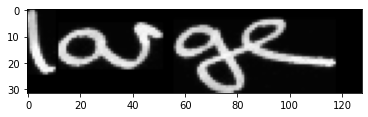



original_text =   majority
predicted text = majority

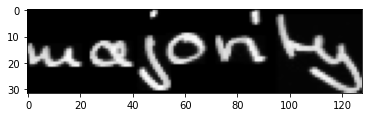



original_text =   of
predicted text = of

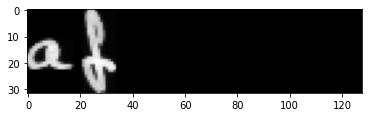



original_text =   Labour
predicted text = Labour

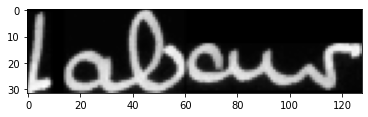



original_text =   MPs
predicted text = MPs

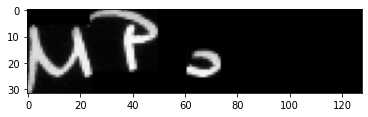



original_text =   are
predicted text = are

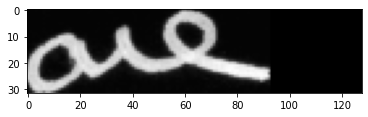



original_text =   to
predicted text = to

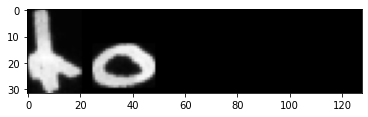



original_text =   turn
predicted text = twn

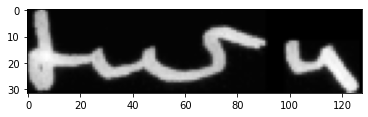



original_text =   down
predicted text = down

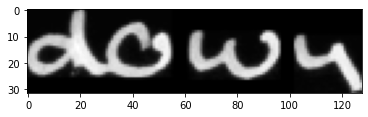



original_text =   the
predicted text = the

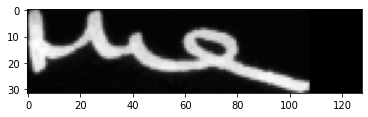



original_text =   Foot-
predicted text = Foot-

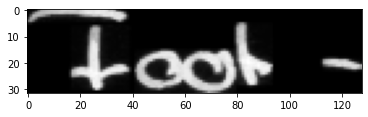



original_text =   be
predicted text = be

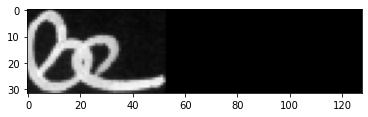



original_text =   that
predicted text = that

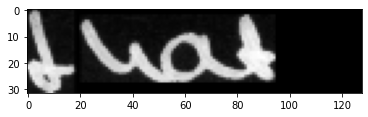



original_text =   as
predicted text = as

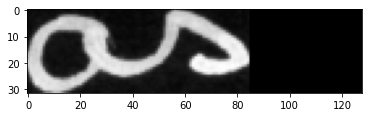



original_text =   Labour
predicted text = Labour

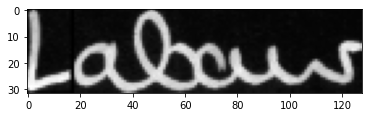



original_text =   MPs
predicted text = MPs

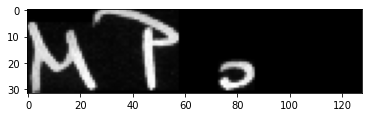



original_text =   opposed
predicted text = opposed

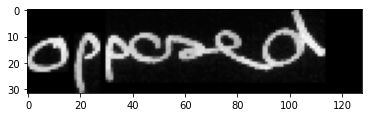



original_text =   the
predicted text = the

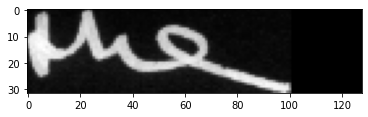



original_text =   Bill
predicted text = Bill

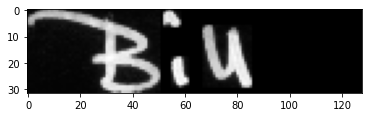



original_text =   which
predicted text = which

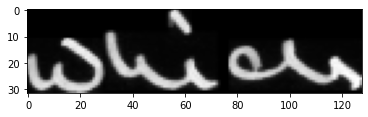

In [ ]:
# predict outputs on validation images
prediction = act_model.predict(train_images[150:170])

# use CTC decoder
decoded = K.ctc_decode(prediction,
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for i, x in enumerate(out):
    print("original_text =  ", train_original_text[150+i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(character[int(p)], end = '')
    plt.imshow(train_images[150+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')

In [ ]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

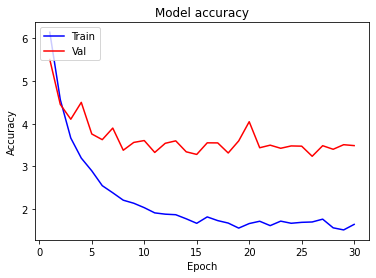

In [ ]:
plotgraph(epochs, loss, val_loss)

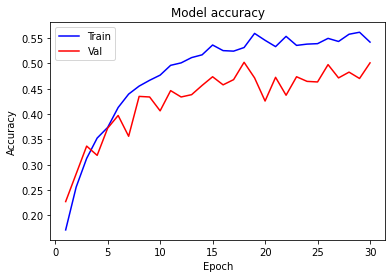

In [ ]:
plotgraph(epochs, acc, val_acc)